# Time Series

## 基本概念

### Autocorrelation 和 Partial Autocorrelation

这部分有参考：

1. [Autocorrelation and Partial Autocorrelation](https://ww2.mathworks.cn/help/releases/R2019a/econ/autocorrelation-and-partial-autocorrelation.html)
2. [A Gentle Introduction to Autocorrelation and Partial Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)。
3. [Partial correlation](https://en.wikipedia.org/wiki/Partial_correlation)

自相关和偏自相关分析是时间序列分析和预测中很常用的方法。

Autocorrelation is the linear dependence of a variable with itself at two points in time.自相关就是变量自身两个时间点之间的线性相关性。协方差$Cov(y_t,y_{t-h})=\gamma _h$，而lag-h自相关系数定义为：$\rho _h=Corr(y_t,y_{t-h})=\frac{\gamma _h}{\gamma _0}$，其中$\gamma _0$是方差。

Partial autocorrelation is the autocorrelation between $y_t$ and $y_{t–h}$ after **removing any linear dependence on $y_1, y_2, ..., y_{t–h+1}$**. The partial lag-h autocorrelation is denoted $\phi_{h,h}$. 

接下来通过一些程序阐述这俩概念。

In [2]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
print(series.head())
series.plot()
pyplot.show()

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


<Figure size 640x480 with 1 Axes>

统计相关可分析变量之间关系，We can assume the distribution of each variable fits a Gaussian (bell curve) distribution. 那么可以使用 the Pearson’s correlation coefficient to summarize the correlation between the variables. 如果是对变量自身不同之间值之间的相关性分析，那么就是自相关性了－－ AutoCorrelation Function， acf。

使用statsmodels库可以绘制自相关性图。

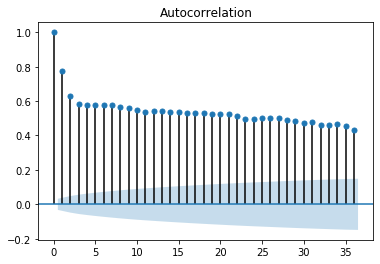

In [3]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
plot_acf(series)
pyplot.show()

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. 也就是说偏相关仅仅描述一个观测和它的lag之间的direct relationship。那些indirect的关系是指其他观测带来的一种对观测和它的lag之间的relationship的影响。为什么要这样考虑，是因为如果只纯粹的考虑两者之间的相关性，会把comfounding的变量的影响考虑进来，即对被分析的这两个变量都有影响的变量，这会导致misleading的信息，因为A和B之间的关系，可能是C导致的，而不是真正的A和B之间的关系，所以要采用偏相关分析。

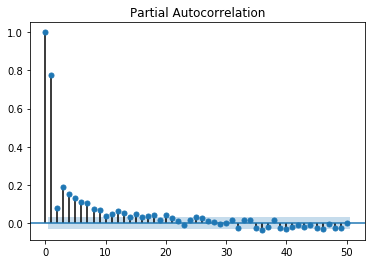

In [4]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
plot_pacf(series, lags=50)
pyplot.show()

### 时间序列的分解

接下来的一些概念参考了[FACEBOOK 时间序列预测算法 PROPHET 的研究](https://zr9558.com/2018/11/30/timeseriespredictionfbprophet/)。

Facebook 所提供的 prophet 算法不仅可以处理时间序列存在一些异常值的情况，也可以处理部分缺失值的情形，还能够几乎全自动地预测时间序列未来的走势。

在时间序列分析领域，有一种常见的分析方法叫做**时间序列的分解（Decomposition of Time Series）**，它把时间序列 $y_{t}$ 分成几个部分，分别是季节项 $S_{t}$，趋势项 $T_{t}$，剩余项 $R_{t}$。也就是说对所有的 $t\geq 0$，都有：$y_{t}=S_{t}+T_{t}+R_{t}$；除了加法的形式，还有乘法的形式，也就是：$y_{t}=S_{t}×T_{t}×R_{t}$.以上式子等价于 $\ln y_{t} = \ln S_{t} + \ln T_{t} + \ln R_{t}$。所以，有的时候在预测模型的时候，会先取对数，然后再进行时间序列的分解，就能得到乘法的形式。

一般来说，在实际生活和生产环节中，除了季节项，趋势项，剩余项之外，通常还有节假日的效应。所以，在 prophet 算法里面，作者同时考虑了以上四项，也就是：$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$. 其中 g(t) 表示趋势项，它表示时间序列在非周期上面的变化趋势；s(t) 表示周期项，或者称为季节项，一般来说是以周或者年为单位；h(t) 表示节假日项，表示在当天是否存在节假日；$\epsilon_{t}$ 表示误差项或者称为剩余项。Prophet 算法就是通过拟合这几项，然后最后把它们累加起来就得到了时间序列的预测值。

### 趋势项模型 g(t)

在 Prophet 算法里面，趋势项有两个重要的函数，一个是基于逻辑回归函数（logistic function）的，另一个是基于分段线性函数（piecewise linear function）的。

暂时个人需要，先看看分段线性函数趋势项，线性函数指的是 y=kx+b, 而分段线性函数指的是在每一个子区间上，函数都是线性函数，但是在整段区间上，函数并不完全是线性的。正如下图所示，分段线性函数就是一个折线的形状。因此，基于分段线性函数的模型形如：
$$g(t)=(k+\boldsymbol{a}(t)\boldsymbol{\delta})\cdot t+(m+\boldsymbol{a}(t)^{T}\boldsymbol{\gamma})$$
 k 表示增长率（growth rate），$\boldsymbol{\delta}$  表示增长率的变化量，m 表示 offset parameter。而这两种方法（分段线性函数与逻辑回归函数）最大的区别就是 $\boldsymbol{\gamma}$  的设置不一样，在分段线性函数中，$\boldsymbol{\gamma}=(\gamma_{1},\cdots,\gamma_{S})^{T}, \gamma_{j}=-s_{j}\delta_{j}$. 注意：这与之前逻辑回归函数中的设置是不一样的。
 
### Detrend

Detrending is removing a trend from a time series. 去趋势就是将时间序列过程中的趋势项去掉。这样就能看到其他产生数据波动的项了。python中可以直接使用scipy库来实现。

piecewise linear detrend就是分段线性趋势的去除了。

In [1]:
import numpy as np
from scipy import signal
randgen = np.random.RandomState(9)
npoints = 1000
noise = randgen.randn(npoints)
x = 3 + 2*np.linspace(0, 1, npoints) + noise
# Remove linear trend along axis from data.
print((signal.detrend(x) - noise).max() < 0.01)

True


## AR

最简单的时间序列分析模型－－AR模型。

这部分AR的相关内容参考了：

1. [Autoregression Models for Time Series Forecasting With Python](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)
2. [matlab文档](https://www.mathworks.com/help/dsp/ref/yulewalkerarestimator.html)
3. [自回归模型（AR Model）](http://geodesy.blog.sohu.com/273714573.html)
4. [百度百科](https://baike.baidu.com/item/%E5%B0%A4%E5%B0%94%E4%B8%80%E6%B2%83%E5%85%8B%E6%96%B9%E7%A8%8B)

### 自回归模型概念

自回归模型是用以前时间中的观测输入到一回归方程中以预测未来的值。回归是很基础的内容了，就是一组观测有输入输出，可以拟合曲线，然后可以用于预测下一组输入对应的输出。自回归，就是输入是各个时间点对应的，这些输入被称作lag variables。因为输入是同样变量的历史时间上的值，因此成为自回归。自回归是基于即历史上的观测可以用来预测未来的假设的。在对历史数据分析时，哪个lagged变量和输出有更强的相关性，回归时可以给它更多的权重。因为这种相关也是从变量自身获取的，所以是自相关，也称作序列相关。如果所有lag variables都没有和输出很相关，说明序列不能自回归分析。

前面说到，最好要先判断一个序列是否有自相关性，再来做自回归。可以对1-lag varaible做相关分析。python中有对应函数。

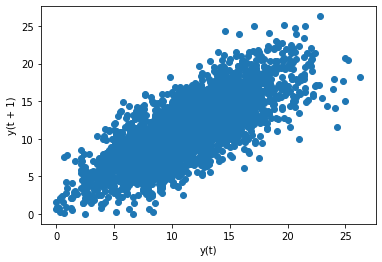

In [3]:
from pandas.plotting import lag_plot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
lag_plot(series)
pyplot.show()

或者也可以直接计算correlation。

In [4]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


也可以直接对许多lag variable和输出之间的correlation分析。在python中也有直接计算的函数。

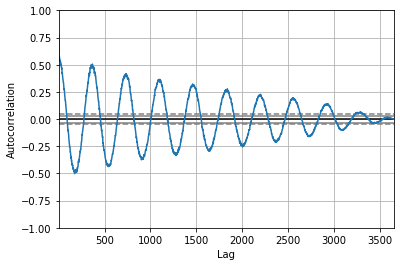

In [6]:
from pandas.plotting import autocorrelation_plot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
autocorrelation_plot(series)
pyplot.show()

### 构建自回归模型

在构建模型之前，需要给一个评价模型的基准，这就是Persistence Model。The simplest model that we could use to make predictions would be to persist the last observation. 这就是Persistence Model。

In [ ]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

An autoregression model is a linear regression model that uses lagged variables as input variables. 在python中可以直接使用statsmodels库的函数。

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### AR模型的求解

上述方法内在的计算方法是：Compute estimate of autoregressive (AR) model parameters using Yule-Walker method.

自相关方法，拟合一AR模型匹配被windowed的输入数据，目标是最小化前向预测误差（ least squares）。这一目标可以导出Yule-Walker方程，该方程可以使用Levinson-Durbin recursion求解。

导出Yule-Walker方程大致的步骤是对自回归方程乘k-lag变量，然后求期望，再除以0-lag的方差，就可以得到lag变量的相关系数间的回归关系式，就是Yule-Walker方程。

尤尔一沃克方程(Yule-Walker equation)是描述自回归序列参数与其协方差函数之间关系的方程。在统计和信号处理中，尤尔一沃克方程与自回归模型关系密切，是一种随机过程的表示，它用于描述自然界，经济学等中的某些时变过程。

具体求解就略了。